# TO DO
- Check if tweet has been made befor the creation date of the user account

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats import pearsonr

In [2]:
tweets_df = pd.read_csv("dataset/tweets_small.csv")
#tweets_df = pd.read_csv("dataset/tweets.csv")
tweets_df.head()

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
0,509354017856950272,327746321,0,0,0,0,0,0,2019-09-11 14:53:55,"If man is a little lower than angels, then ang..."
1,583002592529121280,333722906,1,0,0,0,0,1,2020-04-01 20:27:04,"""@BestWSHHVids: how do you say these words wit..."
2,461498835362013185,2379755827,0,0,0,0,0,1,2019-05-02 13:34:31,@LOLatComedy awsome
3,528808127366692864,466226882,0,0,0,0,0,0,2019-11-04 07:17:37,Stephen Hawkins: i buchi neri non esistono se ...
4,575336690904006656,1355537995,114,0,0,1,0,1,2020-03-11 16:45:31,RT @tibbs_montris: So ready for Wednesday!


In [3]:
users_df = pd.read_csv("dataset/users.csv")
users_df.head()

,id,name,lang,bot,created_at,statuses_count
0,2353593986,Lamonica Raborn,en,1,2019-02-22 18:00:42,76.0
1,2358850842,Lourie Botton,en,0,2019-02-26 03:02:32,54.0
2,137959629,Dadan Syarifudin,en,1,2015-04-30 07:09:56,3.0
3,466124818,Carletto Focia,it,1,2017-01-18 02:49:18,50.0
4,2571493866,MBK Ebook,en,0,2019-06-18 19:30:21,7085.0


# Data Understanding

As you can see from comparing the table above and the function results below, we already have noticed that some values are not as expected. For example all the attributes below are states as objects, but we expect many of them to be numbers. This suggests that we will have to prepare and clean the data thouroghly before they can be used.

## Tweets data

In [4]:
tweets_df.dtypes

id                 int64
user_id            int64
retweet_count      int64
reply_count        int64
favorite_count     int64
num_hashtags       int64
num_urls           int64
num_mentions       int64
created_at        object
text              object
dtype: object

In [5]:
tweets_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              6 non-null      int64 
 1   user_id         6 non-null      int64 
 2   retweet_count   6 non-null      int64 
 3   reply_count     6 non-null      int64 
 4   favorite_count  6 non-null      int64 
 5   num_hashtags    6 non-null      int64 
 6   num_urls        6 non-null      int64 
 7   num_mentions    6 non-null      int64 
 8   created_at      6 non-null      object
 9   text            6 non-null      object
dtypes: int64(8), object(2)
memory usage: 608.0+ bytes


In [6]:
tweets_df.isnull().any() #df[df[0] is None]

id                False
user_id           False
retweet_count     False
reply_count       False
favorite_count    False
num_hashtags      False
num_urls          False
num_mentions      False
created_at        False
text              False
dtype: bool

From the method above we observe that all our atributes except for "created_at" have one or more elements with null values.

In [7]:
"""
wrong_ids = []
for (i,k) in enumerate(df["id"]):
    if not isinstance(k, str) or not k.isnumeric():
        wrong_ids.append(i)
print(len(wrong_ids)/len(df["id"]))
""" 

'\nwrong_ids = []\nfor (i,k) in enumerate(df["id"]):\n    if not isinstance(k, str) or not k.isnumeric():\n        wrong_ids.append(i)\nprint(len(wrong_ids)/len(df["id"]))\n'

### Distribution of variables and statistics
Let's study them!

array([[<AxesSubplot:title={'center':'reply_count'}>,
        <AxesSubplot:title={'center':'retweet_count'}>],
       [<AxesSubplot:title={'center':'favorite_count'}>,
        <AxesSubplot:title={'center':'num_hashtags'}>],
       [<AxesSubplot:title={'center':'num_urls'}>,
        <AxesSubplot:title={'center':'num_mentions'}>]], dtype=object)

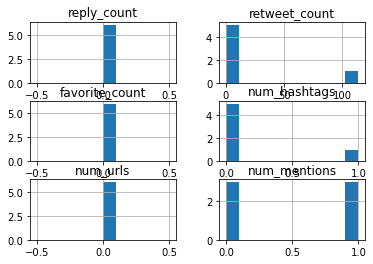

In [8]:
# should we use sturgen rule for number of bins?

tweets_df.hist(column=["reply_count","retweet_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions"])

In [9]:
tweets_df.describe()

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions
count,6.000000e+00,6.000000e+00,6.000000,6.0,6.0,6.000000,6.0,6.000000
mean,5.402415e+17,1.305367e+09,19.166667,0.0,0.0,0.166667,0.0,0.500000
std,4.942106e+16,1.142733e+09,46.460377,0.0,0.0,0.408248,0.0,0.547723
min,4.614988e+17,3.277463e+08,0.000000,0.0,0.0,0.000000,0.0,0.000000
25%,5.142175e+17,3.668489e+08,0.000000,0.0,0.0,0.000000,0.0,0.000000
50%,5.520724e+17,9.108824e+08,0.000000,0.0,0.0,0.000000,0.0,0.500000
75%,5.810861e+17,2.123701e+09,0.750000,0.0,0.0,0.000000,0.0,1.000000
max,5.834487e+17,2.969211e+09,114.000000,0.0,0.0,1.000000,0.0,1.000000


### Assessing data quality

### Variables trasformations (?)

### Pairwise correlations

## Users Data

In [10]:
users_df.dtypes

id                  int64
name               object
lang               object
bot                 int64
created_at         object
statuses_count    float64
dtype: object

In [11]:
users_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 539.6+ KB


In [12]:
users_df.isnull().any() #df[df[0] is None]

id                False
name               True
lang              False
bot               False
created_at        False
statuses_count     True
dtype: bool

### Distribution of variables and statistics
Let's study them!

In [14]:
# should we use sturgen rule for number of bins?

# maybe for sstatuses_count we should use a log-plot
#users_df.hist(column=["statuses_count"], log=True)
#users_df.hist(column=["statuses_count"], by="bot", log=True)

# bar plot for language

sns.barplot(users_df, x="lang")

TypeError: Horizontal orientation requires numeric `x` variable.

In [ ]:
users_df.describe()